In [1]:
%matplotlib notebook

# 3) Complete spectrum analysis

In this example, we shall fit all the emission lines on the spectrum of the Green Pea galaxy GP121903 [(see Fernandez et al 2021)](https://arxiv.org/abs/2110.07741). You can download this spectrum from the [github examples folder](https://github.com/Vital-Fernandez/lime/tree/master/examples).

This tutorial can also be found as a python script in the [github 3rd example](https://github.com/Vital-Fernandez/lime/blob/master/examples/example3_fit_with_external_files.py).

In this exercise, we are going to use the recommended $LiMe$ workflow: Two external files with the lines
masks and fitting configuration.

Let's start by importing the script packages and defining a function to read the ISIS spectrograph *.fits* files:

In [2]:
import numpy as np
from astropy.io import fits

In [3]:
# This try import is only necessary for the developper to compile the documentation from this notebook
try:
    import lime
except ImportError:
    import sys
    sys.path.append('../../../src')
    import lime

In [1]:
def import_osiris_fits(file_address, ext=0):

    # Open the fits file
    with fits.open(file_address) as hdul:
        data, header = hdul[ext].data, hdul[ext].header

    # Reconstruct the wavelength array from the header data
    w_min, dw, n_pix = header['CRVAL1'],  header['CD1_1'], header['NAXIS1']
    w_max = w_min + dw * n_pix
    wavelength = np.linspace(w_min, w_max, n_pix, endpoint=False)

    return wavelength, data, header

## Scientific inputs

Now, we declare and load the scientific data:

In [5]:
# State the data files
obsFitsFile = './sample_data/gp121903_ISIS_spectrum.fits'
lineBandsFile = './sample_data/osiris_bands.txt'
configFile = './sample_data/osiris_conf.ini'

# Load spectrum
wave, flux, header = import_osiris_fits(obsFitsFile)

Now, we are going to load the bands table. The mask ``lineBandsFile`` consists in a text file where the line bands are stored space-separated columns. The first column has the line label (in the $LiMe$ format). The remaining 6 columns specify the line location along with two adjacent continua regions. The image belows shows the bands for the *H1_3889A* line:

<img src="../_static/mask_selection.jpg" alt="Image showing the bands selection for a line" title="Bands for the H1_3889A line"/>



<div class="alert alert-info">

**Please remember:** The band wavelengths must be on the rest frame and sorted from lower to higher values. Finally, make sure that these wavelengths are in the same units as those from your spectrum. 

</div>

You can load the bands file as a [pandas dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) using the ``load_log`` function:

In [6]:
# Load line bands
bands = lime.load_log(lineBandsFile)

In [7]:
print(bands.loc['H1_3889A_m'])

w1    3806.90
w2    3828.20
w3    3880.39
w4    3899.42
w5    3905.00
w6    3950.00
Name: H1_3889A_m, dtype: float64


Now we need to read the configuration file. This is a text file which uses the conventional ini configuration format 
[conventional ini configuration format](https://en.wikipedia.org/wiki/INI_file):
    

<img src="../_static/3_conf_file.png" alt="Image showing the bands selection for a line" title="Bands for the H1_3889A line"/>


These files are organised in *sections*, which are written with squared brackets in the text file. Each section can have several *options*, whose value is assigned with the equal symbol.

<div class="alert alert-info">

**Please remember:** In most cases, the names for the configuration file sections and options do not matter. Nonetheless, the user is recommended to use suffixes, such as *_line_fitting*, to take advantage of $LiMe$ automations. 

</div>

Beyond the default formatting done by the [configparser library](https://docs.python.org/3/library/configparser.html), $LiMe$ converts variable types if the following keywords are found:

* Option values which contain commas (,) will be converted into an array. This is done by splitting the text string by the commas.
* Option names with the _list or _array will be converted into a ``list`` of strings or a float ``numpy.array`` respectively.
  This applies even if there are no commas (for a single value array).
* Option names with the _check suffix will be converted to a boolean. The text string needs to follow the values accepted by
  the [strtobool](https://docs.python.org/3/distutils/apiref.html):
* Options names with the _folder or _file suffices will be left as strings.
* Section names containing the keyword ``_line_fitting`` have an special treatment:
    * If the option value contains colons (:) it will be converted into a dictionary, where each new dictionary entry is
      determined from the presence of commas (,).
    * If the option values which contain colons have a keyword matching the [LmFit](https://lmfit.github.io/lmfit-py/parameters.html).
      attributes (value, vary, min, max, expr) it will be converted to the expected variable type.

This conversion is done by the ``.load_cfg`` once the file is loaded:

In [8]:
# Load configuration
obs_cfg = lime.load_cfg(configFile)

The obs_cfg variable is a dictionary of dictionaries, where each section and option names are keys of the parent and child dictionaries respectively:

In [9]:
import pprint
pprint.pprint(obs_cfg)

{'data_location': {'data_folder': './sample_data',
                   'results_folder': './measurements'},
 'gp121903_line_fitting': {'Ar4_4711A_m': 'Ar4_4711A-He1_4713A',
                           'H1_3889A_m': 'H1_3889A-He1_3889A',
                           'H1_6563A_b': 'H1_6563A-N2_6584A-N2_6548A',
                           'N2_6548A_amp': {'expr': 'N2_6584A_amp/2.94'},
                           'N2_6548A_kinem': 'N2_6584A',
                           'O1_6300A_b': 'O1_6300A-S3_6312A',
                           'O2_3726A_m': 'O2_3726A-O2_3729A',
                           'O2_7319A_m': 'O2_7319A-O2_7330A',
                           'O3_5006.8A_b': 'O3_5006.8A-O3_5006.8A_w1',
                           'O3_5006.8A_w1_sigma': {'expr': '>1.2*O3_5007A_sigma'},
                           'S2_6716A_b': 'S2_6716A-S2_6731A',
                           'S2_6731A_kinem': 'S2_6716A'},
 'sample_data': {'RV': 3.1,
                 'files_list': ['gp030321_BR.fits',
                       

## Line selection and measurement

Using these data, we can now define the ``lime.Spectrum`` object for GP121903:

<IPython.core.display.Javascript object>


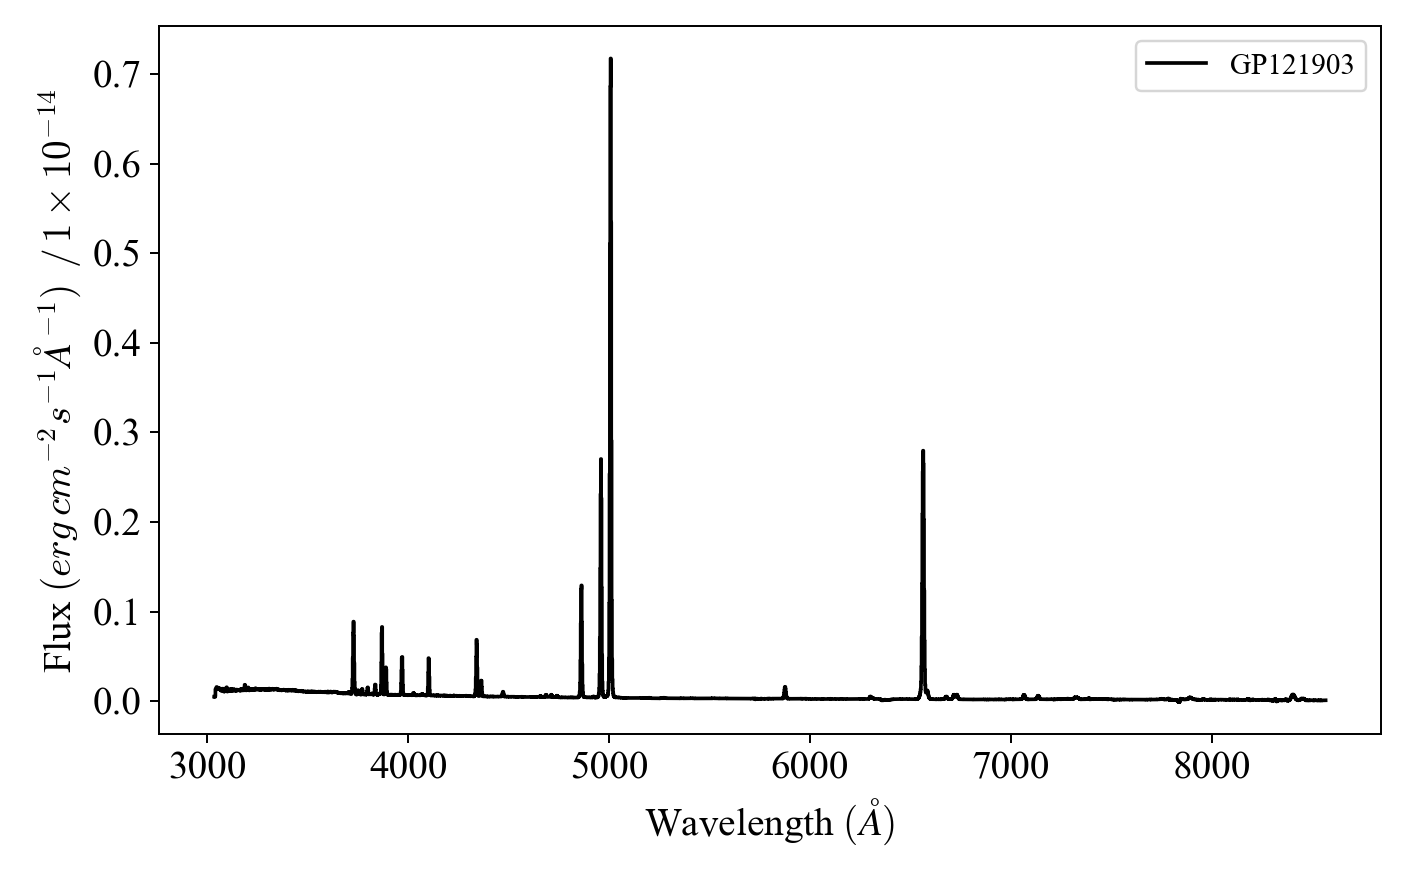

In [10]:
# Declare LiMe spectrum
z_obj = obs_cfg['sample_data']['z_array'][2]
norm_flux = obs_cfg['sample_data']['norm_flux']
gp_spec = lime.Spectrum(wave, flux, redshift=z_obj, norm_flux=norm_flux)
gp_spec.plot.spectrum(label='GP121903', rest_frame=True)

Before fitting the lines on the mask file, it is a good practice to confirm their presence of the spectrum. One way to do that is using the ``.match_line_mask`` function:

In [11]:
# Find the lines
match_bands = gp_spec.line_detection(bands, poly_degree=[3, 7, 7, 7], emis_threshold=[5, 3, 2, 0.7])

This function normalizes the continuum in a loop to find the pixels above and below a certain threshold. Afterwards, the peaks or throughs found are compaired against the input line bands for a succesful line detection.

You can plot a set of bands in you spectrum with the ``line_bands`` argument in the ``.plot.spectrum`` function:

<IPython.core.display.Javascript object>


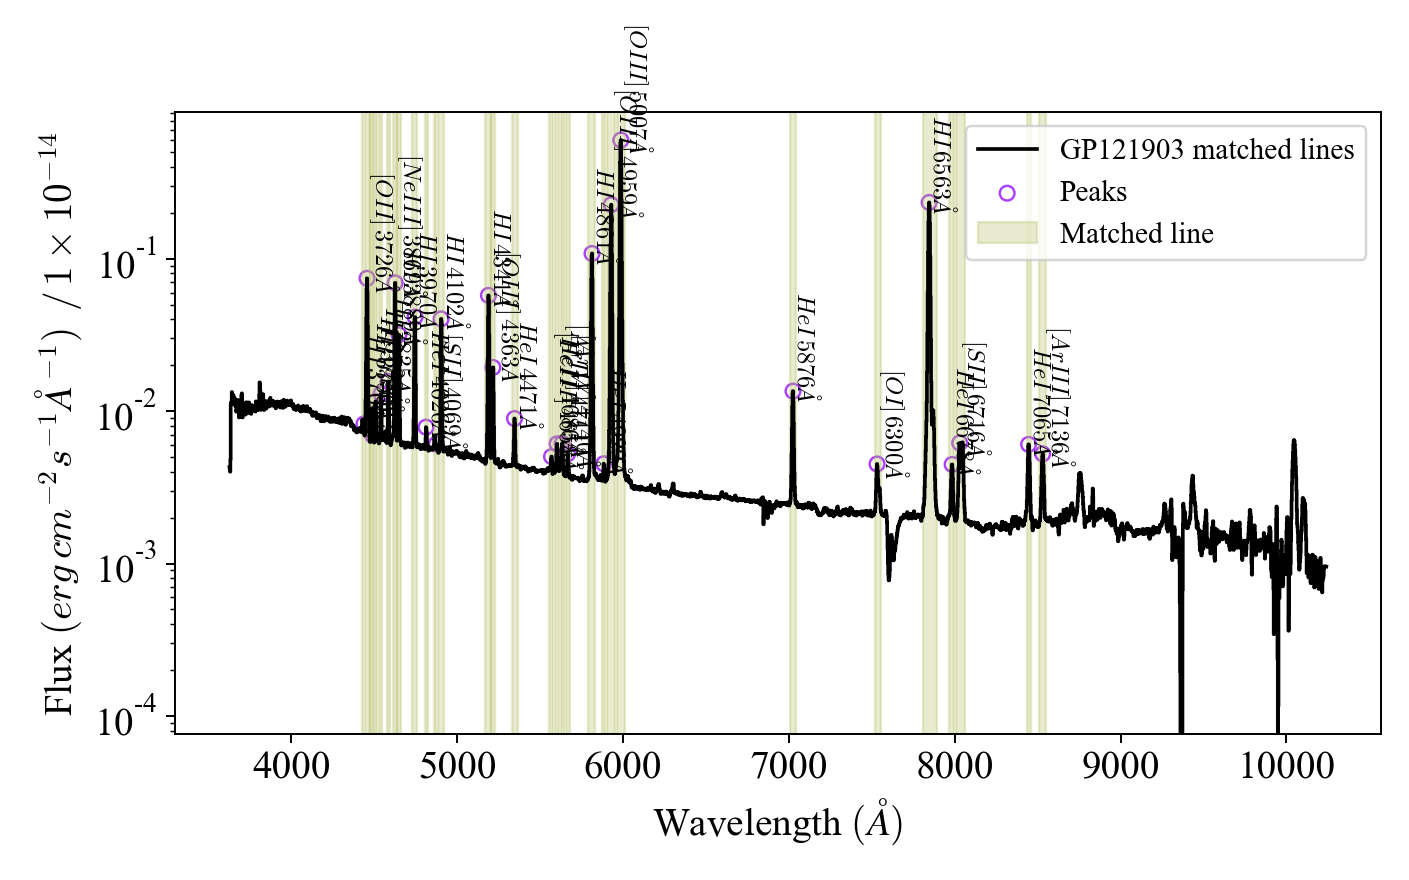

In [12]:
gp_spec.plot.spectrum(label='GP121903 matched lines', line_bands=match_bands, log_scale=True)

You can save your object bands with the ``.save_log`` function:

In [13]:
# Saving GP121903 bands
obj_bands_file = './sample_data/gp121903_bands.txt'
lime.save_log(match_bands, obj_bands_file)

Now we are going to measure all the lines in this bands dataframe using the ``Spectrum.fit.frame`` function:

In [14]:
fit_cfg = obs_cfg['gp121903_line_fitting']
gp_spec.fit.frame(obj_bands_file, fit_cfg, progress_output='bar', plot_fits=False)

[==========] 100%  of lines

## Plotting and saving the measurements

The fitted profiles can be over-plotted on the input spectrum setting the ``include_fits=True`` parameter on the ``Spectrum.plot.spectrum`` function

<IPython.core.display.Javascript object>


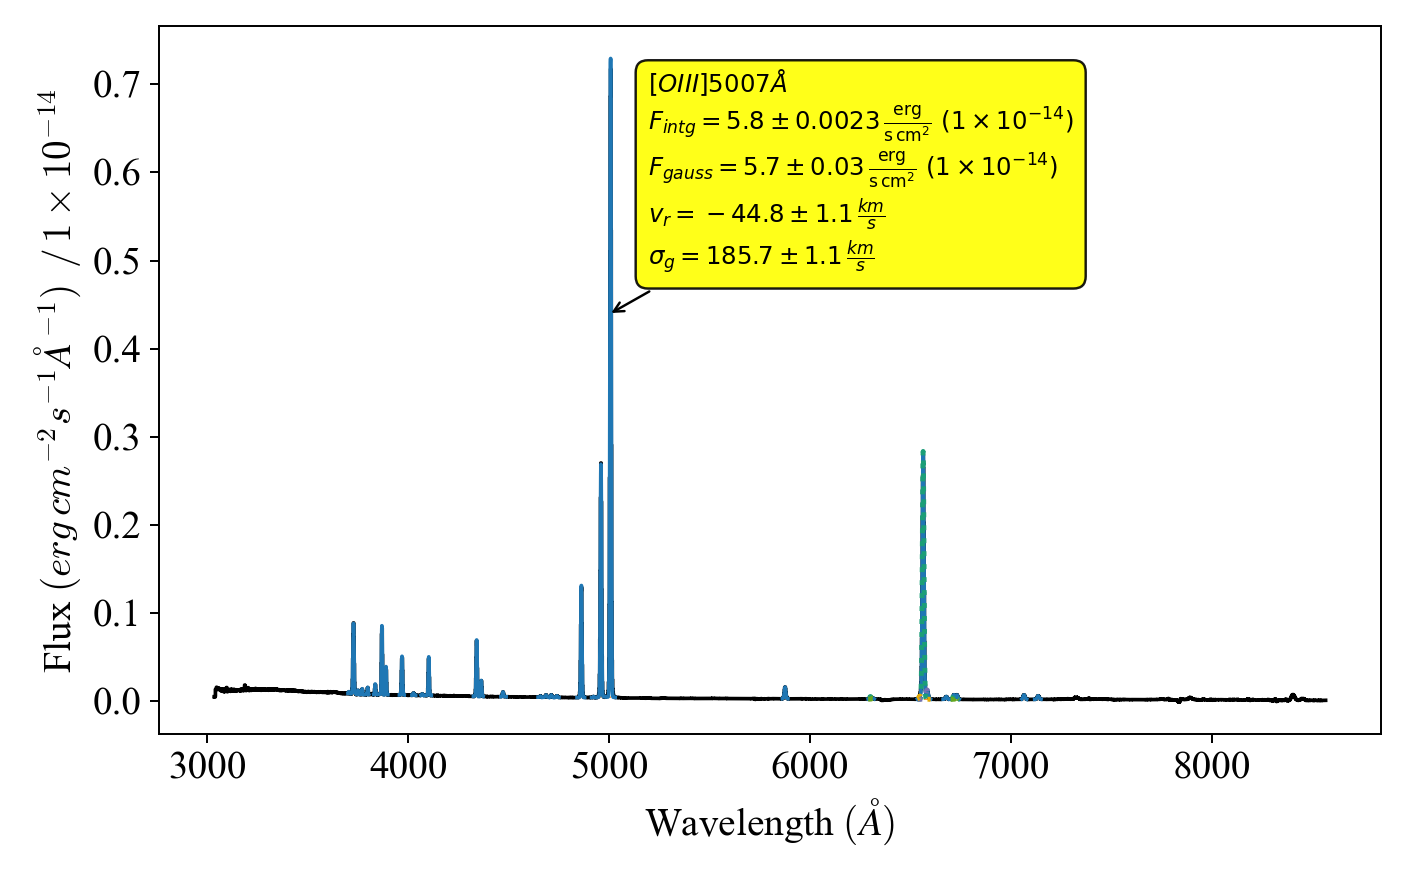

In [15]:
# Display the fits on the spectrum
gp_spec.plot.spectrum(include_fits=True, rest_frame=True)

Additionally, you can also plot the results as a grid using the ``Spectrum.plot.grid``

<IPython.core.display.Javascript object>


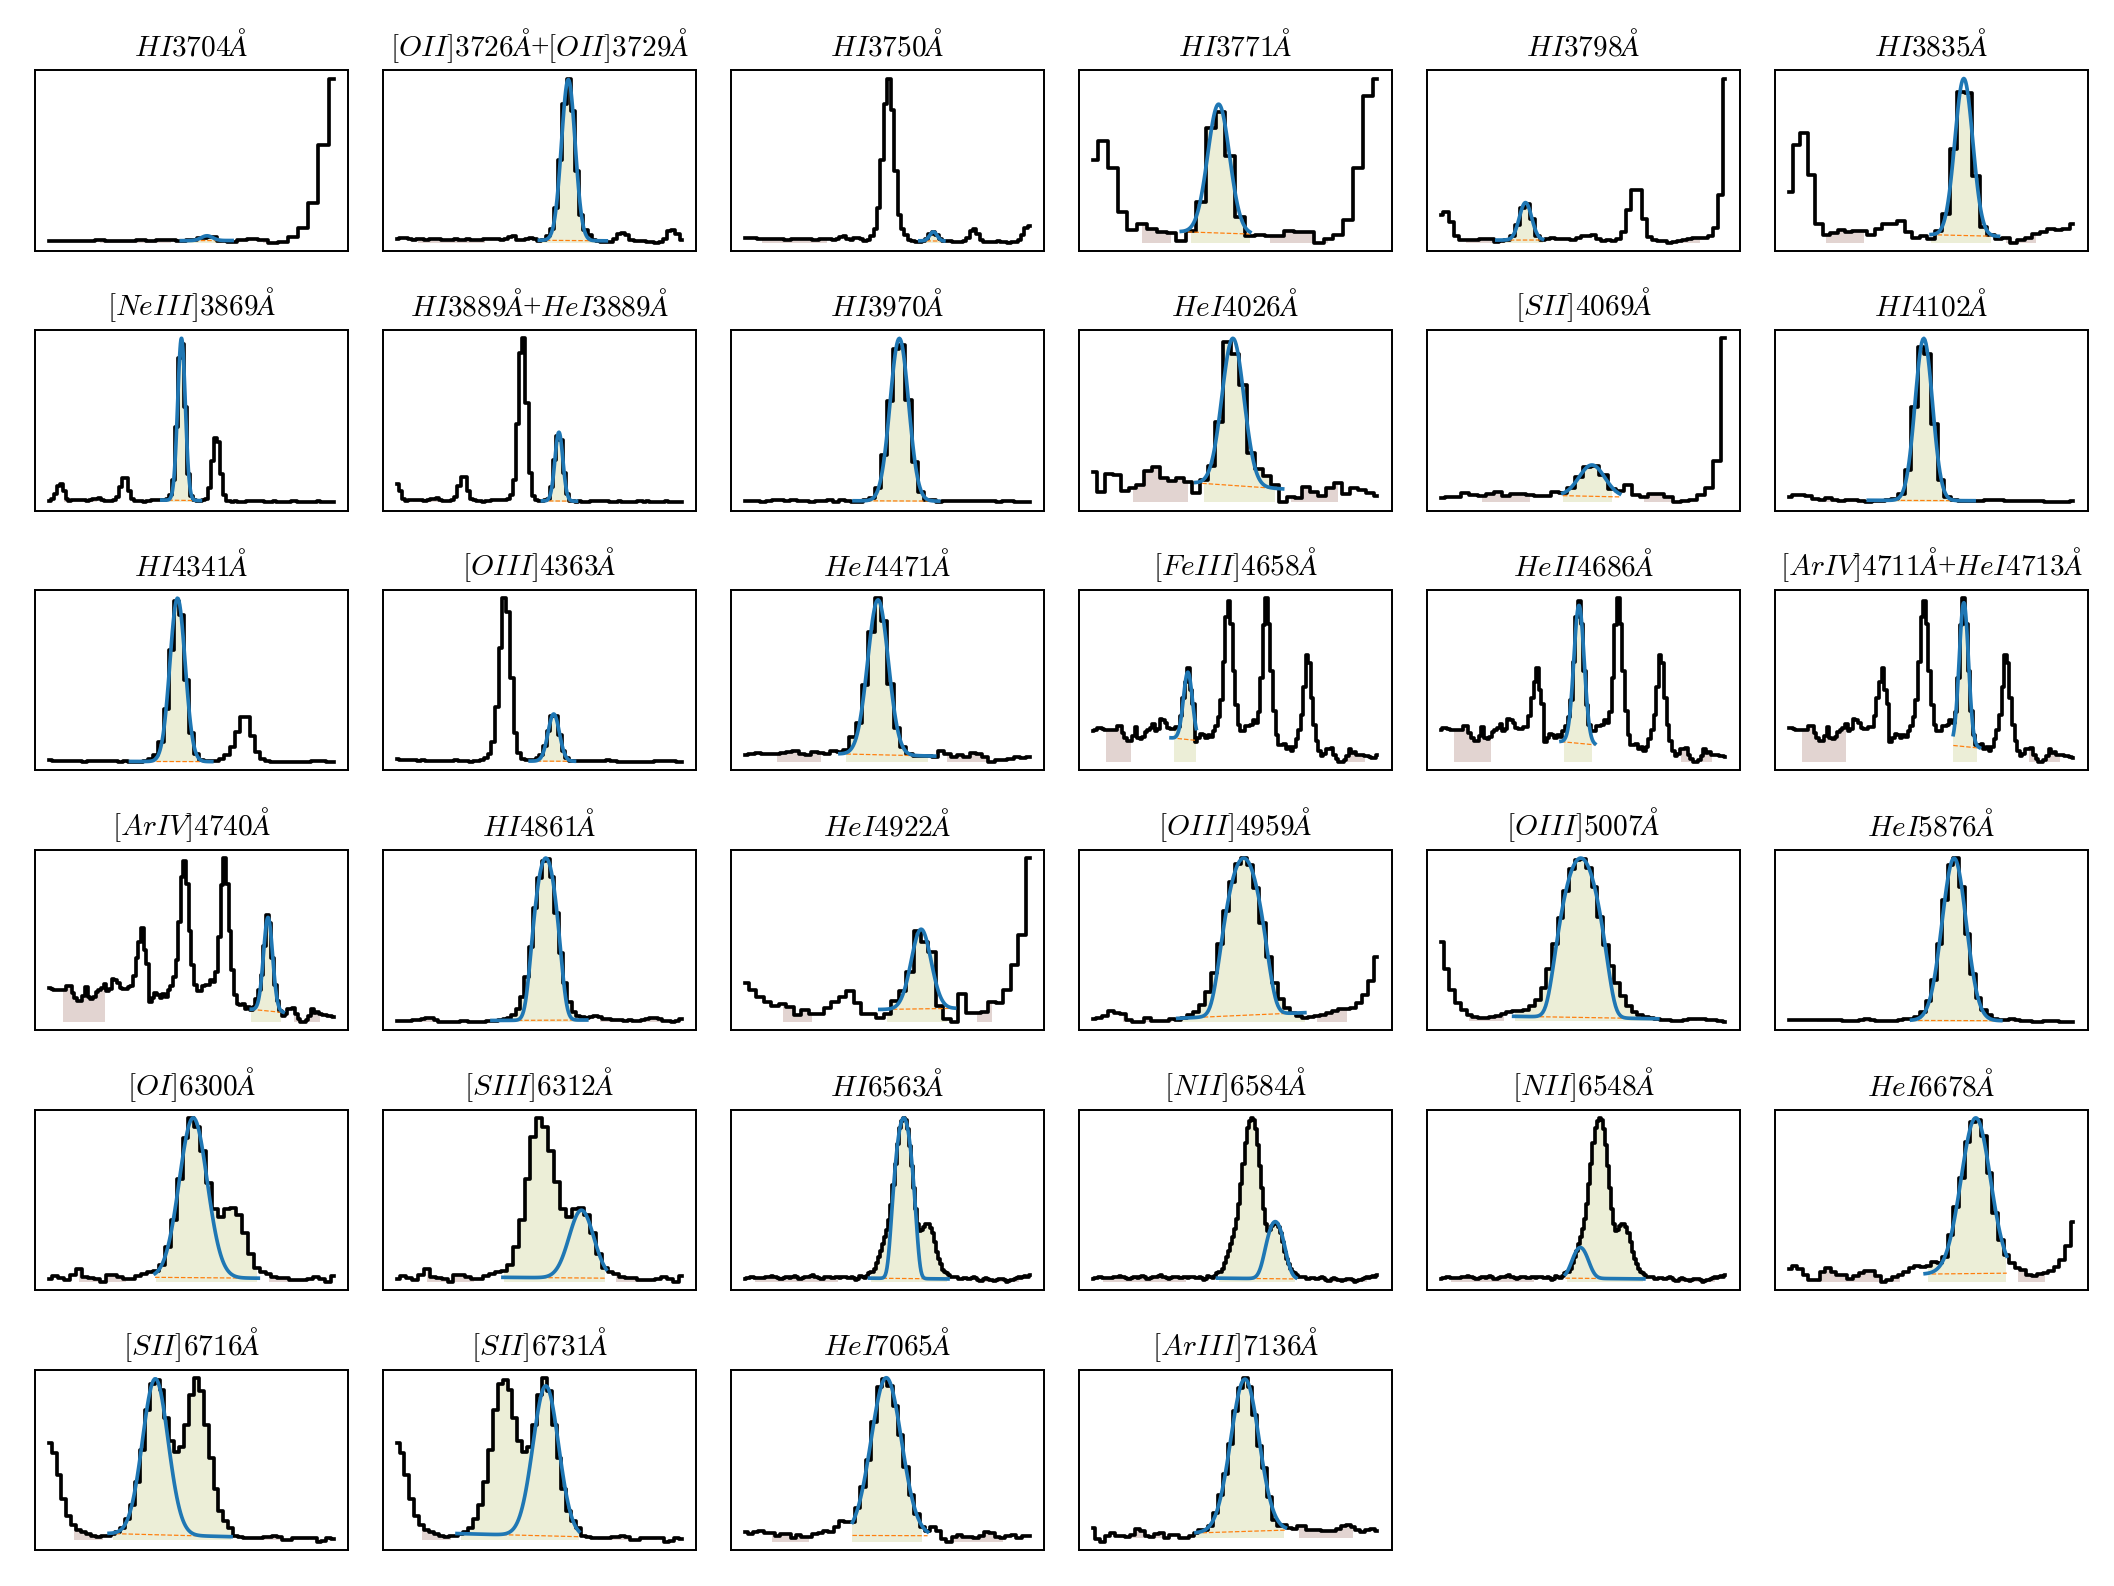

In [19]:
# Display a grid with the fits
gp_spec.plot.grid(gp_spec.log, rest_frame=True)

You can plot individual line fittings with the ``Spectrum.plot.band`` function:

<IPython.core.display.Javascript object>


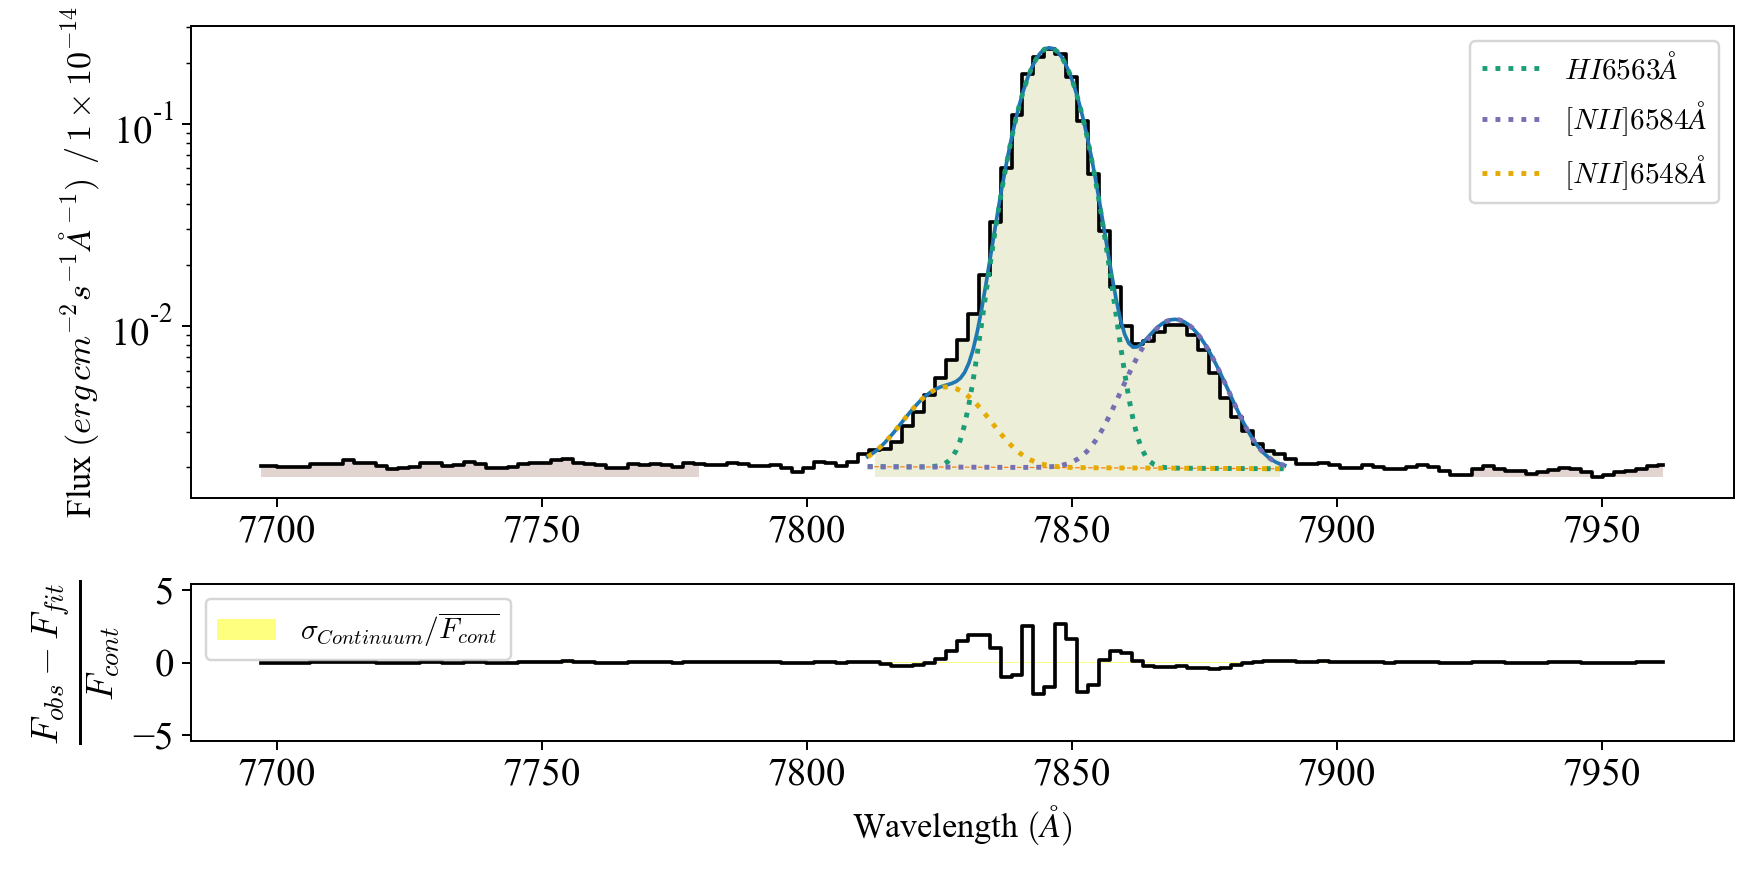

In [20]:
gp_spec.plot.band('H1_6563A')

Finally, we save the tabulated measurements with:

In [17]:
# Save the data
gp_spec.save_log('./sample_data/example3_linelog.fits', ext='GP121903_a')

or

In [ ]:
lime.save_log(gp_spec.log, './sample_data/example3_linelog.fits', ext='GP121903b')